In [1]:
!mkdir results
!ls
!ls results

mkdir: `results' 디렉토리를 만들 수 없습니다: 파일이 있습니다
'CIFAR-10 with Basic CNN.ipynb'   data	 results


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Basic_CNN(nn.Module):
    
    def __init__(self):
        super(Basic_CNN, self).__init__()
        
        self.conv1=nn.Conv2d(3,32,6,2,2)
        self.conv2=nn.Conv2d(32,64,5,2,2)
        self.conv3=nn.Conv2d(64,128,3,1,1)
        self.maxpool=nn.MaxPool2d(2,2)
        self.act=nn.ReLU()
        self.fc=nn.Linear(2048,10)
        
    def forward(self,x):
        x=self.act(self.conv1(x))
        x=self.act(self.conv2(x))
        x=self.act(self.conv3(x))
        x=self.maxpool(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x

In [5]:
def dimension_check():
    net=Basic_CNN()
    x=torch.randn(1,3,32,32)
    y=net(x)
    print(y.shape)

In [6]:
dimension_check()

torch.Size([1, 10])


In [7]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [8]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [9]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [10]:
def experiment(partition, args):
  
    net = Basic_CNN()
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size'] ## epoch, batch_size는 실험에 영향을 미치지 않는 변수이기 때문에 삭제

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) ## result라는 dic에 setting도 합치기 위함
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [12]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_l2"

# ====== Model Capacity ====== #

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 128
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'lr'
list_var1 = [0.00001, 0.00005, 0.0001]
list_var2 = [0.0015, 0.001]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) ## args.name_var1 = var1 과 같은 말
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(epoch=10, exp_name='exp1_lr_l2', l2=1e-05, lr=0.0015, optim='Adam', test_batch_size=1024, train_batch_size=128)
Epoch 0, Acc(train/val): 44.76/54.41, Loss(train/val) 1.53/1.28. Took 3.84 sec
Epoch 1, Acc(train/val): 58.63/60.17, Loss(train/val) 1.17/1.12. Took 3.47 sec
Epoch 2, Acc(train/val): 64.94/62.50, Loss(train/val) 1.00/1.06. Took 3.49 sec
Epoch 3, Acc(train/val): 69.48/65.73, Loss(train/val) 0.87/0.98. Took 3.61 sec
Epoch 4, Acc(train/val): 73.53/65.60, Loss(train/val) 0.76/1.00. Took 3.58 sec
Epoch 5, Acc(train/val): 76.66/67.53, Loss(train/val) 0.67/0.96. Took 3.49 sec
Epoch 6, Acc(train/val): 79.58/66.07, Loss(train/val) 0.58/1.05. Took 3.50 sec
Epoch 7, Acc(train/val): 82.28/66.52, Loss(train/val) 0.51/1.12. Took 3.49 sec
Epoch 8, Acc(train/val): 84.75/66.49, Loss(train/val) 0.43/1.17. Took 3.51 sec
Epoch 9, Acc(train/val): 86.90/64.85, Loss(train/val) 0.37/1.34. Took 3.59 sec
Namespace(epoch=10, exp_name='exp1_lr_l2', l2=1e-05, lr=0.001, optim='Adam', test_batch_

In [13]:
!ls results

exp1_lr_l2-4ab110.json	exp1_lr_l2-7a5960.json	exp1_lr_l2-d6c484.json
exp1_lr_l2-60dbba.json	exp1_lr_l2-b0e635.json	exp1_lr_l2-e1cca9.json


<AxesSubplot:xlabel='l2', ylabel='test_acc'>

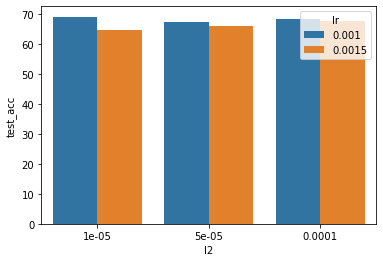

In [17]:
results=load_exp_result('exp1')
import seaborn as sns
sns.barplot(x='l2',y='test_acc',hue='lr',data=results)

<AxesSubplot:xlabel='l2', ylabel='test_acc'>

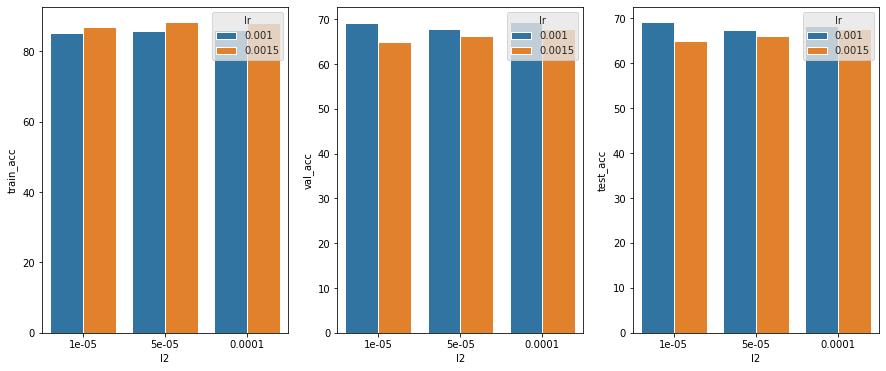

In [19]:
import matplotlib.pyplot as plt

df=load_exp_result('exp1')

fig, ax=plt.subplots(1,3)
fig.set_size_inches(15,6)
sns.set_style("darkgrid", {"axes.facecolor":".9"})

sns.barplot(x='l2', y='train_acc', hue='lr', data=df, ax=ax[0])
sns.barplot(x='l2', y='val_acc', hue='lr', data=df, ax=ax[1])
sns.barplot(x='l2', y='test_acc', hue='lr', data=df, ax=ax[2])

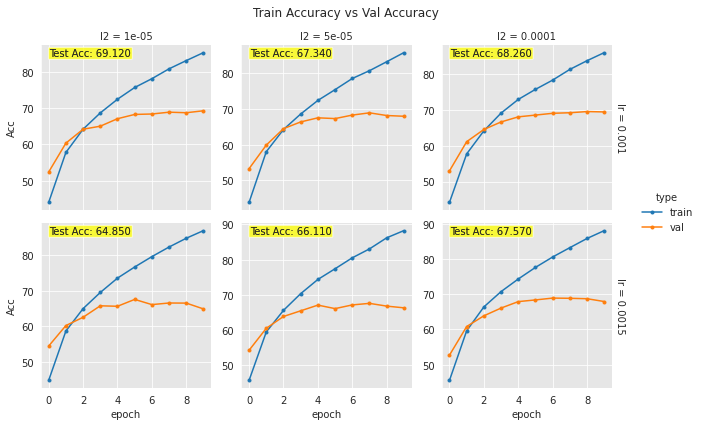

In [20]:
var1 = 'l2'
var2 = 'lr'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

[1.e-05 5.e-05 1.e-04] [0.0015 0.001 ]


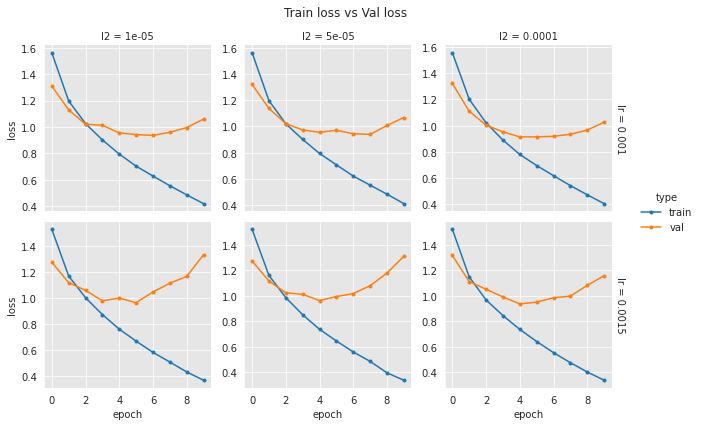

In [21]:
var1 = 'l2'
var2 = 'lr'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)